In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.interpolate import griddata

mpl.font_manager.fontManager.addfont('/opt/localdata/Data/bea/nlp/bmi550/assignment2/Tinos-Regular.ttf')
mpl.rc('font', family='Tinos')

In [2]:
log_path = "/opt/localdata/Data/bea/nlp/bmi550/project/Chronic_Pain_Sentiment_NLP/models/chronic_pain_self_report/logs/roberta_opt_2.json"

# open the log file
opt_df = pd.read_json(log_path, lines=True)
opt_df

,final,params,test_loss,test_acc,test_auc,test_f1,test_prec,test_rec
0,False,"{'dropout_proportion': 0.48336394003933303, 'l...",0.123949,0.900151,0.935612,0.602410,0.862069,0.462963
1,False,"{'dropout_proportion': 0.156504919121461, 'lea...",0.043283,0.913767,0.913243,0.751092,0.710744,0.796296
2,False,"{'dropout_proportion': 0.7116090314698491, 'le...",0.929539,0.931921,0.955026,0.792627,0.788991,0.796296
3,False,"{'dropout_proportion': 0.677060522886134, 'lea...",0.542022,0.916793,0.951544,0.767932,0.705426,0.842593
4,False,"{'dropout_proportion': 0.585307086620329, 'lea...",0.004319,0.921331,0.945700,0.750000,0.780000,0.722222
...,...,...,...,...,...,...,...,...
56,False,"{'dropout_proportion': 0.584299674922188, 'lea...",0.298998,0.928896,0.951468,0.783410,0.779817,0.787037
57,False,"{'dropout_proportion': 0.15645132899168102, 'l...",0.134604,0.898638,0.919948,0.645503,0.753086,0.564815
58,False,"{'dropout_proportion': 0.8340467744233021, 'le...",0.937875,0.919818,0.946973,0.764444,0.735043,0.796296
59,False,"{'dropout_proportion': 0.834169630355407, 'lea...",0.299897,0.925870,0.927726,0.769953,0.780952,0.759259


In [3]:
opt_df.sort_values("test_f1", ascending=False)

,final,params,test_loss,test_acc,test_auc,test_f1,test_prec,test_rec
2,False,"{'dropout_proportion': 0.7116090314698491, 'le...",0.929539,0.931921,0.955026,0.792627,0.788991,0.796296
50,False,"{'dropout_proportion': 0.832419208062763, 'lea...",0.211509,0.933434,0.941598,0.790476,0.813725,0.768519
56,False,"{'dropout_proportion': 0.584299674922188, 'lea...",0.298998,0.928896,0.951468,0.783410,0.779817,0.787037
22,False,"{'dropout_proportion': 0.20576223799960902, 'l...",0.609862,0.918306,0.956466,0.780488,0.695652,0.888889
39,False,"{'dropout_proportion': 0.8332511117590121, 'le...",0.468209,0.925870,0.944947,0.780269,0.756522,0.805556
...,...,...,...,...,...,...,...,...
20,False,"{'dropout_proportion': 0.6986375925952211, 'le...",0.351523,0.894100,0.780658,0.663462,0.690000,0.638889
57,False,"{'dropout_proportion': 0.15645132899168102, 'l...",0.134604,0.898638,0.919948,0.645503,0.753086,0.564815
16,False,"{'dropout_proportion': 0.58713771510384, 'lear...",0.499719,0.838124,0.889684,0.634812,0.502703,0.861111
36,False,"{'dropout_proportion': 0.585215365853982, 'lea...",0.727288,0.898638,0.934180,0.633880,0.773333,0.537037


In [4]:
# extract the best performing parameters based on the monitor metric
best_idx = opt_df["test_f1"].idxmax()
best_param_dict = opt_df.loc[best_idx, 'params']
best_param_dict

{'dropout_proportion': 0.7116090314698491,
 'learning_rate': 1.5360150412472603e-05}

In [5]:
def visualize_v2(x_var: str, y_var: str, z_var: str, df, n: complex = 100j, method: str = 'cubic', best_param_dict: dict or None = None):
    """
    method can be 'linear', 'cubic', or 'nearest'
    """
    var_list = []
    n_list = []
    for var_name in [x_var, y_var]:
        # if variable is 'penalty', convert it to categorical
        var_list.append([d[var_name] for d in df['params']])
        n_list.append(n)
    
    # unpack var_list and n_list
    x_list, y_list = var_list
    x_n, y_n = n_list
    
    # create a grid to interpolate over
    grid_x, grid_y = np.mgrid[min(x_list):max(x_list):x_n, min(y_list):max(y_list):y_n]

    z_list = list(df[z_var])
#     print(z_list)
#     z_list = np.clip(z_list, 0.0, 1.0)

    # interpolate with griddata
    grid_z = griddata((x_list, y_list), z_list, (grid_x, grid_y), method=method, fill_value=0.0)

    fig, ax = plt.subplots(1, 1, dpi=150)
    
    # plot the interpolated data as a density map
    density_map = ax.imshow(
        grid_z.T, 
        extent=(
            min(x_list), 
            max(x_list), 
            min(y_list), 
            max(y_list)
        ), 
        origin='lower', 
        aspect='auto', 
        cmap='viridis',
#         interpolation='gaussian'
    )
    
    if best_param_dict is not None:
        ax.scatter(
            best_param_dict[x_var], 
            best_param_dict[y_var], 
            c='red', 
            marker='x', 
            label="Best Parameters"
        )
        ax.legend()
        

    x_title = x_var.replace('_', ' ').title()
    y_title = y_var.replace('_', ' ').title()
    
    # plt.yscale('log')
    fig.colorbar(density_map, label='F1 Score', ax=ax)
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    ax.set_title(f'Heatmap of {x_title} vs {y_title}')
    plt.show()
    

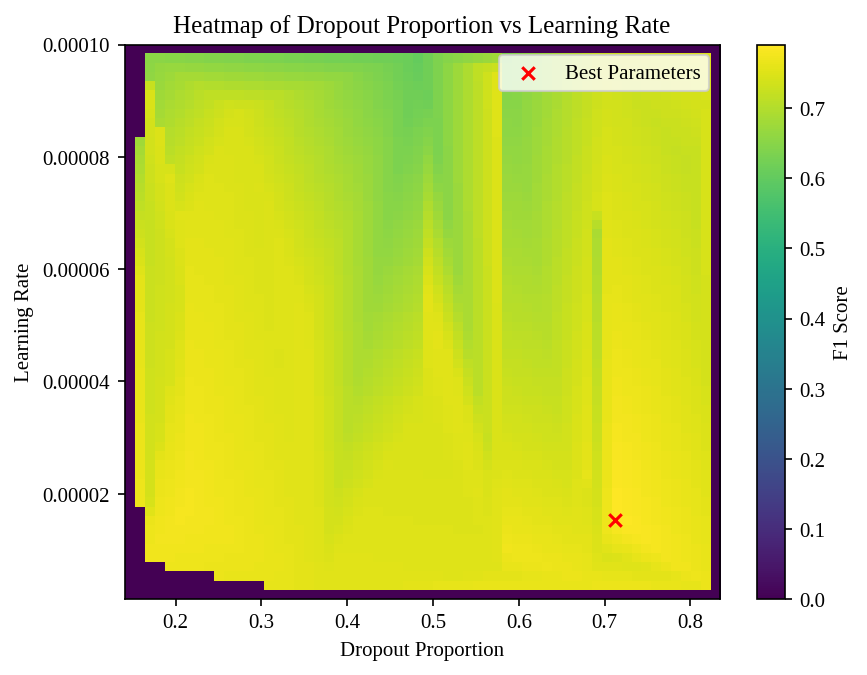

In [6]:
visualize_v2(
    'dropout_proportion', 
    'learning_rate', 
    'test_f1', 
    opt_df[opt_df.final == False], 
    n=60j,
    method='linear',
    best_param_dict=best_param_dict
)